# [**Regressor**] Pytorch를 사용해서 Boston housing 데이터 회귀 모델 만들기


## **1.환경준비**

### (1) 라이브러리 Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

### (2) 필요 함수 생성

* 딥러닝을 위한 데이터로더 만들기

In [3]:
def make_DataSet(x_train, x_val, y_train, y_val, batch_size = 32) :

    # 데이터 텐서로 변환
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

    # TensorDataset 생성 : 텐서 데이터셋으로 합치기
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

    return train_loader, x_val_tensor, y_val_tensor

* 학습을 위한 함수

In [4]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)                  # 전체 데이터셋의 크기
    num_batches = len(dataloader)                   # 배치 크기
    tr_loss = 0
    model.train()                                   # 훈련 모드로 설정
    for batch, (X, y) in enumerate(dataloader):     # batch : 현재 배치 번호, (X, y) : 입력 데이터와 레이블
        X, y = X.to(device), y.to(device)           # 입력 데이터와 레이블을 지정된 장치(device, CPU 또는 GPU)로 연결

        # Feed Forward
        pred = model(X)
        loss = loss_fn(pred, y)
        tr_loss += loss

        # Backpropagation
        loss.backward()             # 역전파를 통해 모델의 각 파라미터에 대한 손실의 기울기를 계산
        optimizer.step()            # 옵티마이저가 계산된 기울기를 사용하여 모델의 파라미터를 업데이트
        optimizer.zero_grad()       # 옵티마이저의 기울기 값 초기화. 기울기가 누적되는 것 방지

    tr_loss /= num_batches          # 모든 배치에서의 loss 평균

    return tr_loss.item()

* 검증을 위한 함수

In [5]:
def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval()

    with torch.no_grad():
        x, y = x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        eval_loss = loss_fn(pred, y).item()

    return eval_loss, pred

* 학습곡선

In [6]:
def dl_learning_curve(tr_loss_list, val_loss_list):

    epochs = list(range(1, len(tr_loss_list)+1))
    plt.plot(epochs, tr_loss_list, label='train_err', marker = '.')
    plt.plot(epochs, val_loss_list, label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) device 준비(cpu or gpu)

In [7]:
# cpu 혹은 gpu 사용
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### (4) 데이터로딩

In [8]:
path = 'https://raw.githubusercontent.com/suku-7/dl_pytorch-study_20250419/refs/heads/main/BostonHousing.csv'
df = pd.read_csv(path)
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


[데이터 컬럼 설명 (데이터 파일명: BostonHousing.csv)]
- crim	: 지역별 범죄율
- zn : 25,000평방피트를 초과하는 주거지역 비율
- indus	: 비소매상업지역 면적 비율
- chas : 찰스강 인접 여부 (1: 인접, 0: 비접)
- nox	: 일산화질소 농도
- rm	: 주택당 평균 방 수
- age	: 1940년 이전에 건축된 주택 비율
- dis	: 직업센터와의 거리
- rad	: 방사형 고속도로 접근성
- tax	: 재산세율 (10,000달러당)
- ptratio	: 학생-교사 비율
- b	: 흑인 거주 비율 지수 (1000(Bk - 0.63)^2, Bk는 흑인 비율)
- lstat	: 하위 계층 비율 (%)
- medv : 주택 가격의 중앙값 (단위: $1,000)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       501 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


## **2.데이터 준비**

### (1) 데이터 준비

In [10]:
# 결측치 확인
df.isnull().sum()

,0
crim,0
zn,0
indus,0
chas,0
nox,0
rm,5
age,0
dis,0
rad,0
tax,0


In [11]:
# 결측치 제거
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     501 non-null    float64
 1   zn       501 non-null    float64
 2   indus    501 non-null    float64
 3   chas     501 non-null    int64  
 4   nox      501 non-null    float64
 5   rm       501 non-null    float64
 6   age      501 non-null    float64
 7   dis      501 non-null    float64
 8   rad      501 non-null    int64  
 9   tax      501 non-null    int64  
 10  ptratio  501 non-null    float64
 11  b        501 non-null    float64
 12  lstat    501 non-null    float64
 13  medv     501 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 58.7 KB


In [12]:
# 데이터 확인
df.head(2)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6


In [13]:
# 데이터를 확인하고, 불필요해 보이는 컬럼을 제거
# zn(25000평방피트를 초과하는 주거지역 비율), chas(찰스강 인접 여부 (1: 인접, 0: 비접)), rad(방사형 고속도로 접근성), b(흑인 거주 비율 지수)

df = df.drop(['zn', 'chas', 'rad', 'b'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, 0 to 505
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     501 non-null    float64
 1   indus    501 non-null    float64
 2   nox      501 non-null    float64
 3   rm       501 non-null    float64
 4   age      501 non-null    float64
 5   dis      501 non-null    float64
 6   tax      501 non-null    int64  
 7   ptratio  501 non-null    float64
 8   lstat    501 non-null    float64
 9   medv     501 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 43.1 KB


In [14]:
features = df.drop('medv', axis=1)
target = df['medv']

### (2) 가변수화

### (3) 데이터분할

In [15]:
x_train, x_valid, y_train, y_valid = train_test_split(features, target, test_size=0.2, random_state = 42)

### (4) Scaling

In [16]:
# 스케일러 선언
mms = MinMaxScaler()
x_train = mms.fit_transform(x_train)
x_valid = mms.transform(x_valid)

##3.모델링

### (1) 딥러닝을 위한 준비작업

* make_DataLoader
    * train : 미니 배치 처리를 위한 데이터 로더로 만들기
    * val : 검증셋으로 성능 측정하면 되므로 텐서 그대로 사용

In [17]:
train_loader, x_valid_ts, y_valid_ts = make_DataSet(x_train, x_valid, y_train, y_valid, 32)

In [18]:
# 첫번째 배치만 로딩해서 살펴보기
for x, y in train_loader:
    print(f"Shape of x [rows, columns]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of x [rows, columns]: torch.Size([32, 9])
Shape of y: torch.Size([32, 1]) torch.float32


### (2) 모델 선언

In [19]:
n_feature = x_train.shape[-1]
n_class = 1

# 모델 구조 설계
model = nn.Sequential(nn.Linear(n_feature, 64),
                      nn.ReLU(),
                      nn.Dropout(p=0.2),
                      nn.Linear(64, 32),
                      nn.ReLU(),
                      nn.Dropout(p=0.2),
                      nn.Linear(32, 16),
                      nn.ReLU(),
                      nn.Dropout(p=0.2),
                      nn.Linear(16, n_class)
        ).to(device)

print(model)

Sequential(
  (0): Linear(in_features=9, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=32, out_features=16, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=16, out_features=1, bias=True)
)


* Loss function과 Optimizer
    * loss function : MSE
    * Optimizer : Adam(모델 파라미터, 학습률)

In [20]:
loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

### (3) 학습

In [21]:
epochs = 100
tr_loss_list, val_loss_list = [], []

# early stopping을 위한 변수 설정 ----------------
patience = 5
best_loss = float('inf')  # 초기값을 무한대로 설정
counter = 0
# ------------------------------------------------

for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss,_= evaluate(x_valid_ts, y_valid_ts, model, loss_fn, device)

    # 리스트에 추가
    tr_loss_list.append(tr_loss)     # train - CrossEntropy
    val_loss_list.append(val_loss)   # val - CrossEntropy

    print(f"Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

    # early stopping 확인 -------------------
    if val_loss > best_loss:
            counter += 1
            print(f'--> early stopping status, best_loss : {best_loss:4f}, counter : {counter}')

    else:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pt')  # 💾 best 모델의 파라미터 저장
        print(f"✔️ Best model saved at epoch {t+1} with val loss: {best_loss:.4f}")  # ✅ 저장 메시지

    # 조기 종료 조건 확인
    if counter >= patience:
        print("Early Stopping!")
        break
    # ----------------------------------------







Epoch 1, train loss : 614.572021, val loss : 522.933777
✔️ Best model saved at epoch 1 with val loss: 522.9338
Epoch 2, train loss : 610.519287, val loss : 518.742310
✔️ Best model saved at epoch 2 with val loss: 518.7423
Epoch 3, train loss : 596.569031, val loss : 513.154053
✔️ Best model saved at epoch 3 with val loss: 513.1541
Epoch 4, train loss : 606.635315, val loss : 501.413025
✔️ Best model saved at epoch 4 with val loss: 501.4130
Epoch 5, train loss : 575.424133, val loss : 474.421692
✔️ Best model saved at epoch 5 with val loss: 474.4217
Epoch 6, train loss : 529.910583, val loss : 417.952698
✔️ Best model saved at epoch 6 with val loss: 417.9527
Epoch 7, train loss : 442.612183, val loss : 321.941620
✔️ Best model saved at epoch 7 with val loss: 321.9416
Epoch 8, train loss : 323.234924, val loss : 207.364349
✔️ Best model saved at epoch 8 with val loss: 207.3643
Epoch 9, train loss : 213.085785, val loss : 149.118713
✔️ Best model saved at epoch 9 with val loss: 149.1187
E

* 학습 곡선

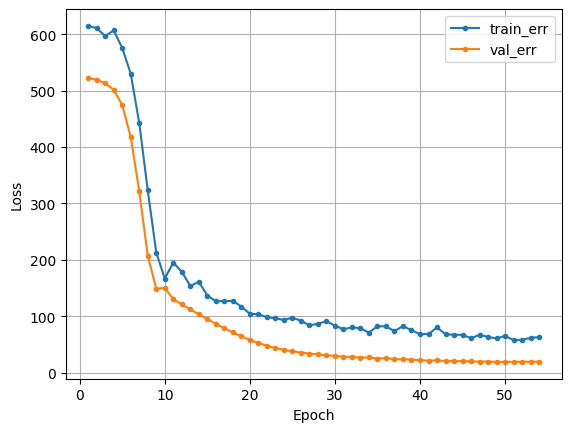

In [22]:
dl_learning_curve(tr_loss_list, val_loss_list)

### (4) 모델 평가

In [23]:
loss, pred = evaluate(x_valid_ts, y_valid_ts, model, loss_fn, device)
print(f'MSE : {loss}')

MSE : 19.5933895111084


In [24]:
mae = mean_absolute_error(y_valid_ts.numpy(), pred.numpy())
mape = mean_absolute_percentage_error(y_valid_ts.numpy(), pred.numpy())
mse = mean_squared_error(y_valid_ts.numpy(), pred.numpy())
rmse = root_mean_squared_error(y_valid_ts.numpy(), pred.numpy())
r2_score = r2_score(y_valid_ts.numpy(), pred.numpy())
print(f'MAE : {mae}')
print(f'MAPE : {mape}')
print(f'MSE : {mse}')
print(f'RMSE : {rmse}')
print(f'r2_score : {r2_score}')

MAE : 3.0546860694885254
MAPE : 0.16668495535850525
MSE : 19.5933895111084
RMSE : 4.4264421463012695
r2_score : 0.7348376512527466
